# Content-Based and User-Based Filtering Anime Movie Recommender System
Steps:
1. Collect anime movie data
2. Extract features and Data Preprocessing
4. Find Cosine Similarity for Content-Based 
5. Find Correlation for User-Based
5. Generate hybrid recommendation 

# Library needed to be import

In [69]:
#Pandas tries to determine what dtype to set by analyzing the data in each column.
import pandas as pd
import re
import time
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Variable declaration

In [70]:
# Record start time
start_time = time.time()
#n = number of results/output want print  
n = 10
#target_user = user_id is equal to a specific user 
target_user = int


# Load dataset into dataframe

In [71]:
#to set the low memory to be false because guessing dtypes for each column is very memory demanding. 
anime_movie_data = pd.read_csv('anime.csv', low_memory = False)
anime_movie_data = pd.DataFrame(anime_movie_data)
anime_movie_data

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


In [72]:
#user_rating_data = user rating data
user_rating_data = pd.read_csv('rating.csv', low_memory = False)
user_rating_data = user_rating_data[0:6000000]
new_user_rating = pd.read_csv('newRating.csv', low_memory = False)
user_rating_data = pd.DataFrame(user_rating_data)
user_rating_data = pd.concat([user_rating_data, new_user_rating])
user_rating_data

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
75,75005,10620,9
76,75005,22319,10
77,75005,15689,10
78,75005,33286,4


# Feature Extraction + Data Preprocessing
 Identifying and extracting relevant features from the movie data that can be used to generate recommendations.

# Change Data Type

In [73]:
anime_movie_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [74]:
#change data type
anime_movie_data['episodes'] = anime_movie_data['episodes'].replace('Unknown', -1)
anime_movie_data = anime_movie_data.astype({"name":"string","genre":"string","type":"string","episodes":"int64"})

In [75]:
anime_movie_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  string 
 2   genre     12232 non-null  string 
 3   type      12269 non-null  string 
 4   episodes  12294 non-null  int64  
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(3), string(3)
memory usage: 672.5 KB


In [76]:
user_rating_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6000080 entries, 0 to 79
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 183.1 MB


# Put a meningful variable name

In [77]:
#Rename Variable
anime_movie_data = anime_movie_data.rename(columns={"rating": "avg_rating"})
anime_movie_data.head(5)

,anime_id,name,genre,type,episodes,avg_rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [78]:
#Rename Variable
user_rating_data = user_rating_data.rename(columns={"rating": "user_rating"})
user_rating_data.head(5)

,user_id,anime_id,user_rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


# Removing null value

In [79]:
#Check is missing value in each column of a Data Frame and count the total number of true null or NaN?
anime_movie_data.isna().sum()

anime_id        0
name            0
genre          62
type           25
episodes        0
avg_rating    230
members         0
dtype: int64

In [80]:
#Drop those missing value by removing the row (axis = 0) with missing value; remove column (axis = 1) 
#and inplace = True --> modify the original DataFrame in place.
anime_movie_data.dropna(axis=0, inplace= True)
anime_movie_data.isna().sum()

anime_id      0
name          0
genre         0
type          0
episodes      0
avg_rating    0
members       0
dtype: int64

In [81]:
user_rating_data.isna().sum()

user_id        0
anime_id       0
user_rating    0
dtype: int64

# Removing stop words

In [82]:
tfidf = TfidfVectorizer(stop_words = 'english')


# Clean Text

In [83]:
anime_movie_data

,anime_id,name,genre,type,episodes,avg_rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


In [84]:
# Define a function to clean the text
def clean_text(text):
    # Remove non-alphabetic characters
    text = re.sub('[^a-zA-Z0-9\s]', ' ', text)
    return text

In [85]:
anime_movie_data['name']=anime_movie_data['name'].apply(clean_text)
anime_movie_data

,anime_id,name,genre,type,episodes,avg_rating,members
0,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama 039,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover Minami tai Mecha Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi Inma Dens...,Hentai,OVA,1,4.98,175


# Remove duplicate records

In [86]:
# Show duplicate rows based on all columns
duplicate_anime = anime_movie_data[anime_movie_data.duplicated()].shape[0]
print(f'Number of duplicate anime records: {duplicate_anime}')

Number of duplicate anime records: 0


In [87]:
duplicate_rating = user_rating_data[user_rating_data.duplicated()].shape[0]
print(f'Number of duplicate rating records: {duplicate_rating}')

Number of duplicate rating records: 1


In [88]:
#keep = specifies which duplicate values to keep, default = first 
#inplace = specify whether to modify the DataFrame in place or to return a new DataFrame with the duplicates removed. 
user_rating_data.drop_duplicates(keep='first',inplace=True)
duplicate_rating = user_rating_data[user_rating_data.duplicated()].shape[0]
print(f'Number of duplicate rating records: {duplicate_rating}')

Number of duplicate rating records: 0


# Merging 2 dataset based on anime_id

In [89]:
merge_data = pd.merge(user_rating_data, anime_movie_data, on='anime_id', sort = True)
merge_data

,user_id,anime_id,user_rating,name,genre,type,episodes,avg_rating,members
0,13,1,-1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824
1,19,1,10,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824
2,21,1,9,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824
3,23,1,9,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824
4,32,1,10,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824
...,...,...,...,...,...,...,...,...,...
5999973,48766,34367,-1,Long Riders Recap,"Comedy, Shounen, Slice of Life, Sports",Special,1,5.97,582
5999974,13954,34475,6,Monster Strike Rain of Memories,"Action, Fantasy, Game",ONA,1,6.58,313
5999975,53492,34475,5,Monster Strike Rain of Memories,"Action, Fantasy, Game",ONA,1,6.58,313
5999976,48766,34476,-1,Platonic Chain Ansatsu Jikkouchuu,"Sci-Fi, Slice of Life",Special,1,1.67,51


In [90]:
#check each anime got how much rating
anime_rating_data = pd.DataFrame(merge_data.groupby('anime_id')['user_rating'].count())
anime_rating_data.head()

,user_rating
anime_id,
1,11729
5,5144
6,8368
7,1843
8,309


# Data Trimming

In [91]:
#to get the number of user rating for each anime 
data_grouping = pd.DataFrame(merge_data.groupby('anime_id')['user_rating'].count()).sort_values(by='user_rating', ascending= False)
data_grouping.describe()

,user_rating
count,11135.000000
mean,538.839515
std,1567.309203
min,1.000000
25%,4.000000
50%,40.000000
75%,299.000000
max,30218.000000


In [92]:
#get the anime that had the number of user rating less than the mean value
trim_data = data_grouping[data_grouping['user_rating'] > data_grouping.mean()[0]]
#trim the data
merge_data = merge_data.loc[merge_data['anime_id'].isin(trim_data.index.values.tolist())]
merge_data

,user_id,anime_id,user_rating,name,genre,type,episodes,avg_rating,members
0,13,1,-1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824
1,19,1,10,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824
2,21,1,9,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824
3,23,1,9,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824
4,32,1,10,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824
...,...,...,...,...,...,...,...,...,...
5999913,55952,34240,8,Shelter,"Music, Sci-Fi",Music,1,8.38,71136
5999914,56035,34240,10,Shelter,"Music, Sci-Fi",Music,1,8.38,71136
5999915,56093,34240,-1,Shelter,"Music, Sci-Fi",Music,1,8.38,71136
5999916,56120,34240,7,Shelter,"Music, Sci-Fi",Music,1,8.38,71136


# Algorithm 1: Content-based filtering

# Construct the TF-IDF matrix

In [93]:
#Compute the TF-IDF matrix based on the name
tfidf_matrix = tfidf.fit_transform(anime_movie_data['name'])
print(type(tfidf_matrix))

<class 'scipy.sparse._csr.csr_matrix'>


In [94]:
tfidf.vocabulary_

{'kimi': 5311,
 'na': 6972,
 'wa': 11116,
 'fullmetal': 2900,
 'alchemist': 386,
 'brotherhood': 1159,
 'gintama': 3239,
 'steins': 9885,
 'gate': 3087,
 '039': 16,
 'haikyuu': 3529,
 'karasuno': 5046,
 'koukou': 5622,
 'vs': 11110,
 'shiratorizawa': 9424,
 'gakuen': 3008,
 'hunter': 4099,
 '2011': 100,
 'ginga': 3229,
 'eiyuu': 2491,
 'densetsu': 2128,
 'movie': 6870,
 'kanketsu': 5002,
 'hen': 3801,
 'yorozuya': 11544,
 'yo': 11471,
 'eien': 2472,
 'nare': 7102,
 'enchousen': 2547,
 'clannad': 1659,
 'story': 9902,
 'koe': 5458,
 'katachi': 5085,
 'code': 1693,
 'geass': 3103,
 'hangyaku': 3653,
 'lelouch': 5949,
 'r2': 8311,
 'second': 9017,
 'season': 9014,
 'sen': 9117,
 'chihiro': 1464,
 'kamikakushi': 4934,
 'shigatsu': 9279,
 'uso': 10978,
 'mushishi': 6944,
 'zoku': 11783,
 'shou': 9509,
 '2nd': 135,
 'ookami': 7674,
 'kodomo': 5456,
 'ame': 431,
 'yuki': 11611,
 'hajime': 3546,
 'ippo': 4385,
 'rurouni': 8696,
 'kenshin': 5196,
 'meiji': 6466,
 'kenkaku': 5182,
 'romantan': 8

# Anime Movie's Name Information

In [95]:
anime_movie_data.name.head()

0                      Kimi no Na wa 
1    Fullmetal Alchemist  Brotherhood
2                            Gintama 
3                         Steins Gate
4                       Gintama  039 
Name: name, dtype: object

In [96]:
name_size = len(anime_movie_data.name)
print(name_size)

12017


# Display movie with same name keywords via 'loc' property
 loc property is used to access a group of rows and columns by label(s)

In [97]:
# Search for the 'Clanned' keyword in name using loc property
anime_by_name = anime_movie_data.copy().loc[anime_movie_data['name'].str.contains('Clannad')]
anime_by_name.head()

,anime_id,name,genre,type,episodes,avg_rating,members
10,4181,Clannad After Story,"Drama, Fantasy, Romance, Slice of Life, Supern...",TV,24,9.06,456749
223,2167,Clannad,"Comedy, Drama, Romance, School, Slice of Life,...",TV,23,8.30,566690
370,4059,Clannad Mou Hitotsu no Sekai Tomoyo hen,"Drama, Romance, School, Slice of Life",Special,1,8.14,160423
504,6351,Clannad After Story Mou Hitotsu no Sekai K...,"Drama, Romance, School",Special,1,8.02,138364
2103,1723,Clannad Movie,"Drama, Fantasy, Romance, School",Movie,1,7.35,99506


# Cosine Similarity

In [98]:
# Compute the Cosine Similarity in terms of pairwise similarities
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [99]:
# Create a pandas series where indexes are values and titles are indexes
indices = pd.Series(anime_movie_data.index, index = anime_movie_data['name']).drop_duplicates()

# Check the first 10 indices of anime 
indices[:n]

name
Kimi no Na wa                                                0
Fullmetal Alchemist  Brotherhood                             1
Gintama                                                      2
Steins Gate                                                  3
Gintama  039                                                 4
Haikyuu    Karasuno Koukou VS Shiratorizawa Gakuen Koukou    5
Hunter x Hunter  2011                                        6
Ginga Eiyuu Densetsu                                         7
Gintama Movie  Kanketsu hen   Yorozuya yo Eien Nare          8
Gintama  039   Enchousen                                     9
dtype: int64

# Recommend anime movie function based on cosine similarity

In [100]:
# Define a function to get recommended movies
def get_recommendations_content_based(name, cosine_sim):
    # Get the index of the movie that matches the name
    index = indices[name]

    # Get the pairwise similarity scores
    sim_scores = list(enumerate(cosine_sim[index]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the top 10 most similar movies
    sim_scores = sim_scores[:n]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return anime_movie_data['name'].iloc[movie_indices],  [i[1] for i in sim_scores]

# User input for the specific user id

In [101]:
target_user = int(input('Enter a user id (75000 - 75005) is the new added user:')) 

# Top 10 recommended anime movie based on the top rating movie name from specific user id 

Text(0, 0.5, 'Frequency')

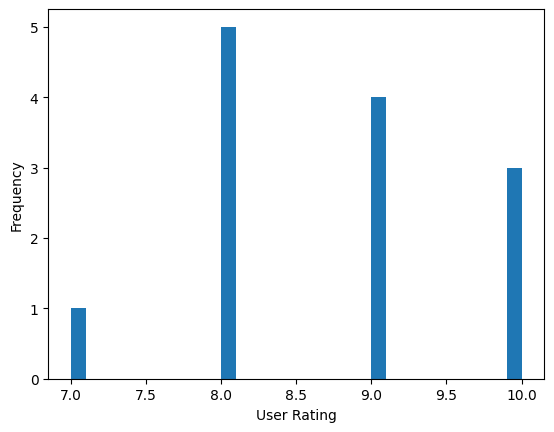

In [102]:
# Get recommendations for a given movie name by a top rated movie from s specific user id 
target_user_data = merge_data[merge_data['user_id'] == target_user].sort_values(by='user_rating', ascending=False)

#print the user_rating histogram 
target_user_rating_data = pd.DataFrame(target_user_data.groupby('anime_id')['user_rating'].mean()).sort_values(by='user_rating', ascending= False)
plt.hist(target_user_rating_data['user_rating'], bins=30)
plt.xlabel('User Rating')
plt.ylabel('Frequency')



In [103]:
#get the top rated anime name from the target user 
name = target_user_data['name'].values[0]

content_based_recommendations, sim_scores = get_recommendations_content_based(name, cosine_sim)


# Print the top 10 recommended movies with the similarity score 
content_based_recommendations=pd.DataFrame(content_based_recommendations)
content_based_recommendations['similarity_score'] = sim_scores[:n]
content_based_recommendations = content_based_recommendations[~content_based_recommendations['name'].isin(target_user_data['name'])]
content_based_recommendations


,name,similarity_score
402,Fullmetal Alchemist Brotherhood Specials,0.950934
200,Fullmetal Alchemist,0.793218
1030,Fullmetal Alchemist Brotherhood 4 Koma Theater,0.775084
1967,Fullmetal Alchemist Reflections,0.605055
1742,Fullmetal Alchemist Premium Collection,0.539734
971,Fullmetal Alchemist The Conqueror of Shamballa,0.508080
1558,Fullmetal Alchemist The Sacred Star of Milos,0.497849
2397,Fullmetal Alchemist The Sacred Star of Milos ...,0.482129
2697,Brotherhood Final Fantasy XV,0.330870


Text(0.5, 1.0, 'Distribution of cosine similarity scores of the anime')

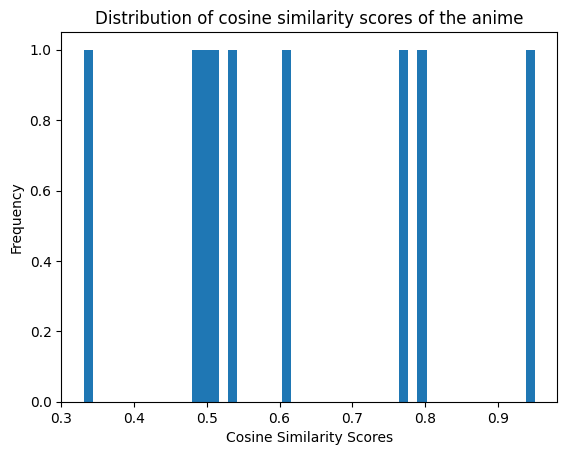

In [104]:
#print the histogram 
plt.hist(content_based_recommendations['similarity_score'], bins=50)
plt.xlabel('Cosine Similarity Scores')
plt.ylabel('Frequency')
plt.title('Distribution of cosine similarity scores of the anime')

# Algorithm 2: User-based collaborative filtering  

# Find the user-item matrix

In [105]:
#matrix which the anime had been rating by the user
user_anime_matrix = merge_data.pivot_table(index = 'user_id', columns = ['anime_id'], values = 'user_rating')
user_anime_matrix.fillna(-1, inplace=True)
user_anime_matrix.head(10)

anime_id,1,5,6,7,15,16,18,19,20,22,...,32668,32681,32729,32828,32935,32998,33028,33558,34103,34240
user_id,,,,,,,,,,,,,,,,,,,,,
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,8.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
5,-1.0,-1.0,8.0,-1.0,6.0,-1.0,6.0,-1.0,6.0,5.0,...,-1.0,-1.0,-1.0,7.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
6,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
7,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,7.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
8,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
9,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [106]:
merge_data.user_rating.info()

<class 'pandas.core.series.Series'>
Index: 5331502 entries, 0 to 5999917
Series name: user_rating
Non-Null Count    Dtype
--------------    -----
5331502 non-null  int64
dtypes: int64(1)
memory usage: 81.4 MB


In [107]:
anime_user_matrix = user_anime_matrix.transpose()
anime_user_matrix.head(10)

user_id,1,2,3,4,5,6,7,8,9,10,...,56310,56311,56312,56313,75000,75001,75002,75003,75004,75005
anime_id,,,,,,,,,,,,,,,,,,,,,
1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,8.0,-1.0,-1.0,-1.0,9.0,-1.0,-1.0,-1.0,-1.0,-1.0
5,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
6,-1.0,-1.0,-1.0,-1.0,8.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,8.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
7,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
15,-1.0,-1.0,-1.0,-1.0,6.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
16,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
18,-1.0,-1.0,-1.0,-1.0,6.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
19,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,10.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
20,-1.0,-1.0,8.0,-1.0,6.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,5.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


# Select a user for target user to compare correlation with other users

In [108]:
anime_user_rating = anime_user_matrix[target_user]
pd.DataFrame(anime_user_rating.sort_values(ascending= False)).rename(columns={target_user: f"user with id {target_user}'s rating"})

,user with id 75000's rating
anime_id,
32935,10.0
5114,10.0
9253,10.0
1,9.0
30276,9.0
...,...
2581,-1.0
2563,-1.0
2520,-1.0


# Find correlation with other users

In [109]:
# Find correlation between user_id = 85 based on the ratings of movies
similar_users = anime_user_matrix.corrwith(anime_user_rating).dropna()
similar_users

user_id
1       -0.003424
2       -0.001711
3        0.059717
5        0.060186
7        0.046377
           ...   
75001    0.308958
75002   -0.005391
75003    0.191267
75004   -0.006763
75005   -0.005900
Length: 53199, dtype: float64

# Transform it into Data Frame

In [110]:
# Create a dataframe with similar movies as the index column and correlation as another column
similar_users = pd.DataFrame(similar_users, columns = ['correlation'])
similar_users.head(10)

,correlation
user_id,
1,-0.003424
2,-0.001711
3,0.059717
5,0.060186
7,0.046377
8,-0.005868
9,-0.001711
10,0.190177
11,0.078057


# Show user with highest correlation

In [111]:
#except the most_similar_users[0] = traget_user  
most_similar_users = similar_users.sort_values(by = 'correlation', ascending = False)
most_similar_users = most_similar_users[1:n]
most_similar_users

,correlation
user_id,
4699,0.494923
8581,0.456588
48526,0.449755
29476,0.447886
39488,0.446999
33690,0.442357
18216,0.440467
42633,0.440159
19908,0.430087


Text(0.5, 1.0, 'Distribution of correlation scores between')

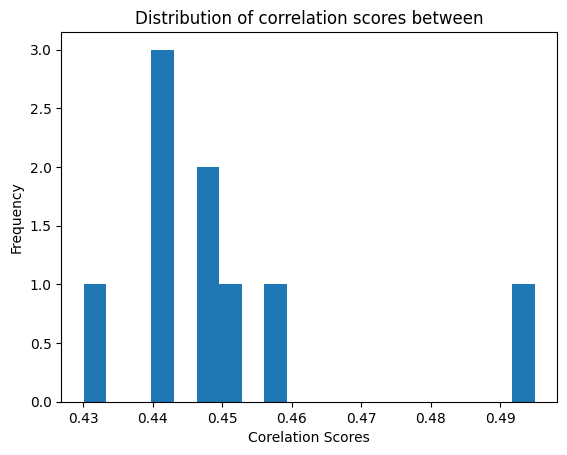

In [112]:
#print the histogram 
plt.hist(most_similar_users['correlation'], bins=20)
plt.xlabel('Corelation Scores')
plt.ylabel('Frequency')
plt.title('Distribution of correlation scores between')

In [113]:
#print user_id with highest correlation
most_similar_users = most_similar_users.index.values.tolist()
highest_correlation_user = most_similar_users[0]
print(f'User with the highest correlation scores: {highest_correlation_user}')


User with the highest correlation scores: 4699


# 10 best recommend rated anime movie from the user that have highest correlation value

In [114]:
#sort highest rating to lowest rating
#target_user = merge_data.loc[merge_data['user_id'] == target_user].sort_values(by= 'user_rating', ascending= False)
#recommend anime movie based on similar user
targeted_user = merge_data[merge_data['user_id'] == target_user].sort_values(by ='user_rating', ascending=False)
#trim those anime records had already exist in the user rating
user_based_recommendations = merge_data[merge_data['user_id'] == highest_correlation_user]
user_based_recommendations = user_based_recommendations.sort_values(by = 'user_rating', ascending=False)
user_based_recommendations = user_based_recommendations[~user_based_recommendations['anime_id'].isin(targeted_user['anime_id'].tolist())]

#display result
user_based_recommendations = user_based_recommendations[:n]
user_based_recommendations


,user_id,anime_id,user_rating,name,genre,type,episodes,avg_rating,members
2110631,4699,2904,10,Code Geass Hangyaku no Lelouch R2,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",TV,25,8.98,572888
1565719,4699,1535,10,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917
4797874,4699,16498,9,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229
1439695,4699,1210,8,NHK ni Youkoso,"Comedy, Drama, Psychological, Romance",TV,24,8.40,291228
5035771,4699,18679,8,Kill la Kill,"Action, Comedy, School, Super Power",TV,24,8.23,508118
1113440,4699,790,7,Ergo Proxy,"Mystery, Psychological, Sci-Fi",TV,23,8.03,265005
4908382,4699,17265,7,Log Horizon,"Action, Adventure, Fantasy, Game, Magic, Shounen",TV,25,8.14,387100
34232,4699,19,6,Monster,"Drama, Horror, Mystery, Police, Psychological,...",TV,74,8.72,247562
4194761,4699,11757,5,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100
733646,4699,379,5,Heppoko Jikken Animation Excel Saga,"Comedy, Parody, Sci-Fi, Shounen",TV,26,7.57,68198


# Final recommended anime movie system: Combine content-based and user-based 

In [115]:
#make each of the result to a list 
content_based_recommendations_list = content_based_recommendations.index.tolist()
print(f'Content-based recommendation list : {content_based_recommendations_list}')

Content-based recommendation list : [402, 200, 1030, 1967, 1742, 971, 1558, 2397, 2697]


In [116]:
user_based_recommendations_list = user_based_recommendations['anime_id'].tolist()
print(f'User-based recommendation list : {user_based_recommendations_list}')

User-based recommendation list : [2904, 1535, 16498, 1210, 18679, 790, 17265, 19, 11757, 379]


In [117]:
final_anime_recommend = content_based_recommendations_list.copy()
final_anime_recommend += user_based_recommendations_list.copy()
print(f'Final anime recommendation list : {final_anime_recommend}')

Final anime recommendation list : [402, 200, 1030, 1967, 1742, 971, 1558, 2397, 2697, 2904, 1535, 16498, 1210, 18679, 790, 17265, 19, 11757, 379]


In [118]:
#the anime that use to do the content based filtering
target_anime = target_user_data.iloc[0]
pd.DataFrame(target_anime)

,2730448
user_id,75000
anime_id,5114
user_rating,10
name,Fullmetal Alchemist Brotherhood
genre,"Action, Adventure, Drama, Fantasy, Magic, Mili..."
type,TV
episodes,64
avg_rating,9.26
members,793665


In [119]:
#the list of the target user's rating 
pd.DataFrame(target_user_data)

,user_id,anime_id,user_rating,name,genre,type,episodes,avg_rating,members
2730448,75000,5114,10,Fullmetal Alchemist Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
3581863,75000,9253,10,Steins Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
5988410,75000,32935,10,Haikyuu Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
11728,75000,1,9,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,8.82,486824
1645554,75000,1575,9,Code Geass Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV,25,8.83,715151
4056738,75000,11061,9,Hunter x Hunter 2011,"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
5817916,75000,30276,9,One Punch Man,"Action, Comedy, Parody, Sci-Fi, Seinen, Super ...",TV,12,8.82,552458
322104,75000,136,8,Hunter x Hunter,"Action, Adventure, Shounen, Super Power",TV,62,8.48,166255
1845233,75000,2001,8,Tengen Toppa Gurren Lagann,"Action, Adventure, Comedy, Mecha, Sci-Fi",TV,27,8.78,562962
2564900,75000,4565,8,Tengen Toppa Gurren Lagann Movie Lagann hen,"Action, Mecha, Sci-Fi, Space, Super Power",Movie,1,8.64,82253


# Display the final recommendation

In [ ]:
pd.DataFrame(merge_data.loc[merge_data['user_id'] == 36051].sort_values(by='user_rating', ascending=False))

In [120]:
recommend_anime = anime_movie_data.loc[anime_movie_data['anime_id'].isin(final_anime_recommend)]
recommend_anime.drop_duplicates(subset=['anime_id'], keep=False)
pd.DataFrame(recommend_anime).iloc[:n]

,anime_id,name,genre,type,episodes,avg_rating,members
13,2904,Code Geass Hangyaku no Lelouch R2,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",TV,25,8.98,572888
38,19,Monster,"Drama, Horror, Mystery, Police, Psychological,...",TV,74,8.72,247562
40,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917
86,16498,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229
156,1210,NHK ni Youkoso,"Comedy, Drama, Psychological, Romance",TV,24,8.40,291228
281,18679,Kill la Kill,"Action, Comedy, School, Super Power",TV,24,8.23,508118
374,17265,Log Horizon,"Action, Adventure, Fantasy, Game, Magic, Shounen",TV,25,8.14,387100
489,790,Ergo Proxy,"Mystery, Psychological, Sci-Fi",TV,23,8.03,265005
804,11757,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100
827,2397,Digimon Adventure Bokura no War Game,"Adventure, Comedy, Kids, Sci-Fi",Movie,1,7.81,37078


In [121]:
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 193.1033411026001 seconds
